In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
speed_of_light = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/speed_of_light) / (1. + v/speed_of_light)
    return np.sqrt(frac)

In [2]:
MODEL_T_COLOR = 'r'
MODEL_STAR_COLOR = 'b'
DATA_COLOR = 'k'

## 51 Peg:

In [3]:
data = wobble.Data('51peg_e2ds.hdf5', filepath='../../data/', 
                   orders=np.arange(72), tensors=False)

In [4]:
data.wobble_obj.load_results('../../results/51peg_wobbleflow.hdf5')

### FIGURE: data and models for random epoch

In [20]:
o = 57
n = 0
t_wave = np.exp(data.wobble_obj.model_xs_t[o] - np.log(doppler(data.wobble_obj.rvs_t[o][n])))
t_flux = np.exp(data.wobble_obj.model_ys_t[o])
s_wave = np.exp(data.wobble_obj.model_xs_star[o] - np.log(doppler(data.wobble_obj.rvs_star[o][n])))
s_flux = np.exp(data.wobble_obj.model_ys_star[o])
d_wave,d_flux = np.exp(data.xs[o][n]), np.exp(data.ys[o][n])

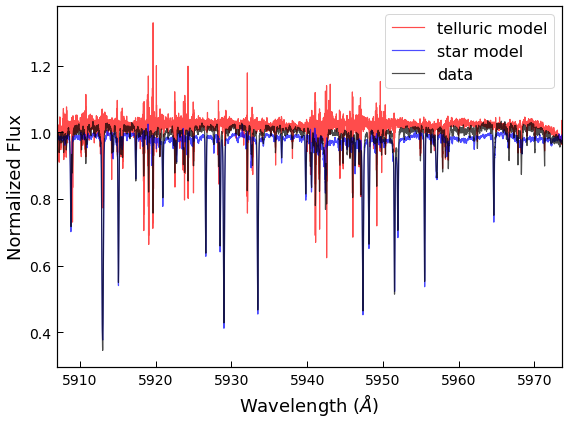

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(t_wave,t_flux,color=MODEL_T_COLOR,alpha=0.7,label='telluric model')
ax.plot(s_wave,s_flux,color=MODEL_STAR_COLOR,alpha=0.7,label='star model')
ax.plot(d_wave,d_flux,color=DATA_COLOR,alpha=0.7,label='data')
ax.set_xlim([min(d_wave),max(d_wave)])
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=18)
ax.set_ylabel('Normalized Flux', fontsize=18)
ax.legend(loc='upper right', fontsize=16)
fig.tight_layout()
fig.savefig('51peg_spectrum.pdf')

### FIGURE: orbit fit

## tellurics model 
#### (still using 51 Peg data)

### FIGURE: tellurics compared to standard star

In [44]:
from harps_hacks import read_harps
from wobble.utils import fit_continuum
f = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T23:40:43.280_e2ds_A.fits'
wave,flux = read_harps.read_spec_2d(f)
snrs = read_harps.read_snr(f)

In [47]:
o = 57
wave2,flux2 = np.exp(data.wobble_obj.model_xs_t[o]), np.exp(data.wobble_obj.model_ys_t[o])
wave1,flux1 = wave[o], flux[o]
ivars1 = np.zeros_like(flux1) + snrs[o]**2 # HACK
flux1 = np.exp(np.log(flux1) - fit_continuum(np.log(wave1), np.log(flux1), ivars1))

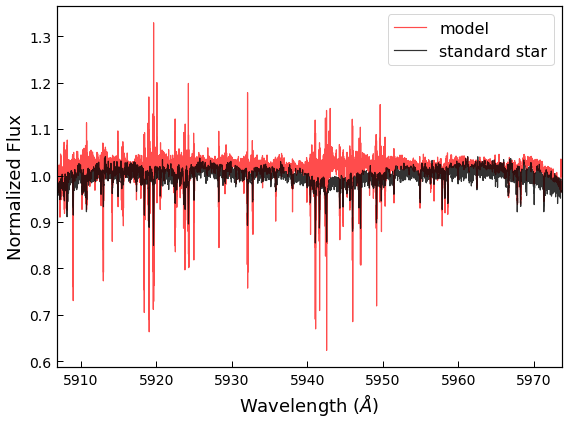

In [63]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wave2,flux2,color=MODEL_T_COLOR,alpha=0.7,label='model')
ax.plot(wave1,flux1,color=DATA_COLOR,alpha=0.8,label='standard star')
ax.set_xlim([min(wave2),max(wave2)])
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=18)
ax.set_ylabel('Normalized Flux', fontsize=18)
ax.legend(loc='upper right', fontsize=16)
fig.tight_layout()
fig.savefig('telluric_standard.pdf')

### FIGURE: telluric components and variability

## quiet M star:

### FIGURE: data and models for random epoch

### FIGURE: time series